# 通过量子神经网络对鸢尾花进行分类

[![查看源文件](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/classification_of_iris_by_qnn.ipynb)

## 概述

在之前的案例中，我们介绍了什么是变分量子线路，并通过一个简单的例子体验了如何搭建量子神经网络来解决一个小问题。在本文档中，我们将体验升级，将会介绍如何通过搭建量子神经网络来解决经典机器学习中的问题。我们选取的问题是：监督学习中的鸢尾花分类问题。

问题描述：鸢尾花（iris）数据集是经典机器学习中常用的数据集，该数据集总共包含150个样本（分为3种不同的亚属：山鸢尾（setosa）、杂色鸢尾（versicolor）和维吉尼亚鸢尾（virginica），每个亚属各有50个样本），每个样本包含4个特征，分别为花萼长度（sepal length）、花萼宽度（sepal width）和花瓣长度（petal length）、花瓣宽度（petal width）。

我们选取前100个样本（山鸢尾（setosa）和杂色鸢尾（versicolor）），并随机抽取80个样本作为训练集，通过搭建量子神经网络对量子分类器（Ansatz）进行训练，学习完成后，对剩余的20个样本进行分类测试，期望预测的准确率尽可能高。

思路：我们需要将100个样本进行划分，分成80个训练样本和20个测试样本，根据训练样本的经典数据计算搭建Encoder所需的参数，然后，搭建Encoder，将训练样本的经典数据编码到量子态上，接着，搭建Ansatz，通过搭建的量子神经网络层和MindSpore的算子对Ansatz中的参数进行训练，进而得到最终的分类器，最后，对剩余的20个测试样本进行分类测试，得到预测的准确率。

## 环境准备

首先，我们需要导入鸢尾花的数据集，而在导入该数据集前，我们需要使用sklearn库中的datasets模块，因此读者需要检查是否安装了sklearn库，可执行如下代码检查。

In [1]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.0.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 


若无报错，则表明已安装。简单说明一下，sklearn是scikit-learn的简称，是一个基于Python的第三方模块。sklearn库集成了一些常用的机器学习方法，在进行机器学习任务时，并不需要实现算法，只需要简单的调用sklearn库中提供的模块就能完成大多数的机器学习任务。

若未安装sklearn库，则可通过运行如下代码来安装。

```bash
pip install scikit-learn
```

然后，我们设置本文档所需的线程数。

In [2]:
import os                                                 # 导入os库
os.environ['OMP_NUM_THREADS'] = '2'                       # 通过os.environ将量子线路模拟器的线程数设置为2

说明：

（1）os是一个标准库，里面包含许多操作文件和目录的函数；

（2）os.environ()模块，可以获取并修改环境变量；一般来说，我们需要在一开始设置线程数；

## 导入鸢尾花数据集

有了上述准备，现在我们就可以导入鸢尾花的数据集了。

In [3]:
import numpy as np                                        # 导入numpy库并简写为np
from sklearn import datasets                              # 导入datasets模块，用于加载鸢尾花的数据集

iris_dataset = datasets.load_iris()                       # 加载鸢尾花的数据集，并存在iris_dataset

print(iris_dataset.data.shape)                            # 打印iris_dataset的样本的数据维度
print(iris_dataset.feature_names)                         # 打印iris_dataset的样本的特征名称
print(iris_dataset.target_names)                          # 打印iris_dataset的样本包含的亚属名称
print(iris_dataset.target)                                # 打印iris_dataset的样本的标签的数组
print(iris_dataset.target.shape)                          # 打印iris_dataset的样本的标签的数据维度

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150,)


从上述打印可以看到，该数据集共有150个样本，每个样本均有4个特征，分别为花萼长度（sepal length）、花萼宽度（sepal width）和花瓣长度（petal length）、花瓣宽度（petal width）。同时样本包含3种不同的亚属：山鸢尾（setosa）、杂色鸢尾（versicolor）和维吉尼亚鸢尾（virginica），每个样本有对应的分类编号，0表示样本属于setosa，1表示样本属于versicolor，2表示样本属于virginica，因此有一个由150个数字组成的数组来表示样本的亚属类型。

由于我们只选取前100个样本，因此执行如下命令。

In [4]:
X = iris_dataset.data[:100, :].astype(np.float32)         # 选取iris_dataset的data的前100个数据，将其数据类型转换为float32，并储存在X中
X_feature_names = iris_dataset.feature_names              # 将iris_dataset的特征名称储存在X_feature_names中
y = iris_dataset.target[:100].astype(int)                 # 选取iris_dataset的target的前100个数据，将其数据类型转换为int，并储存在y中
y_target_names = iris_dataset.target_names[:2]            # 选取iris_dataset的target_names的前2个数据，并储存在y_target_names中

print(X.shape)                                            # 打印样本的数据维度
print(X_feature_names)                                    # 打印样本的特征名称
print(y_target_names)                                     # 打印样本包含的亚属名称
print(y)                                                  # 打印样本的标签的数组
print(y.shape)                                            # 打印样本的标签的数据维度

(100, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(100,)


从上述打印可以看到，此时的数据集`X`中只有100个样本，每个样本依然有4个特征，仍为花萼长度（sepal length）、花萼宽度（sepal width）和花瓣长度（petal length）、花瓣宽度（petal width）。此时只有2种不同的亚属：山鸢尾（setosa）和杂色鸢尾（versicolor），并且每一个样本有对应的分类编号，0表示它属于setosa，1表示它属于versicolor，因此有一个由100个数字组成的数组来表示样本的亚属类型。

## 数据图像化

为了更加直观地了解这100个样本组成的数据集，我们画出所有样本不同特征之间组成的散点图，执行如下命令。

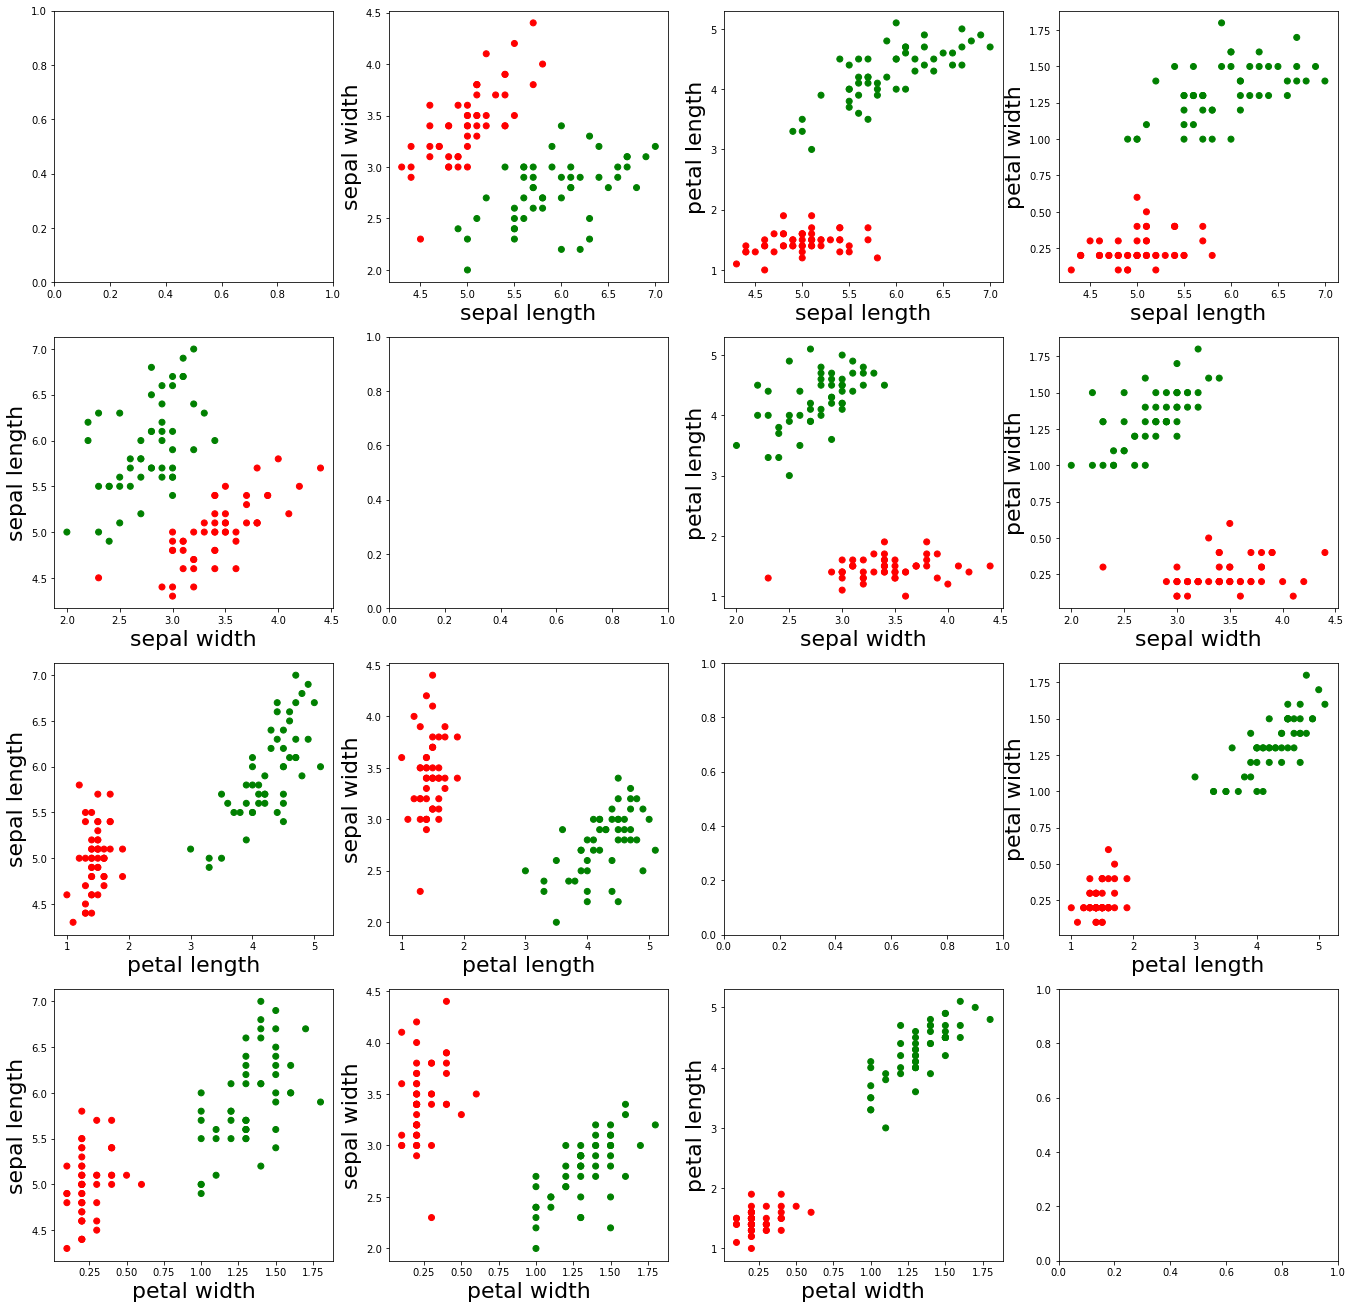

In [5]:
import matplotlib.pyplot as plt                                                           # 导入matplotlib.pyplot模块并简写为plt

feature_name = {0: 'sepal length', 1: 'sepal width', 2: 'petal length', 3: 'petal width'} # 将不同的特征名称分别标记为0,1,2,3
axes = plt.figure(figsize=(23, 23)).subplots(4, 4)                                        # 画出一个大小为23*23的图，包含4*4=16个子图

colormap = {0: 'r', 1: 'g'}                                                               # 将标签为0的样本设为红色，标签为1的样本设为绿色
cvalue = [colormap[i] for i in y]                                                         # 将100个样本对应的标签设置相应的颜色

for i in range(4):
    for j in range(4):
        if i != j:
            ax = axes[i][j]                                                               # 在[i][j]的子图上开始画图
            ax.scatter(X[:, i], X[:, j], c=cvalue)                                        # 画出第[i]个特征和第[j]个特征组成的散点图
            ax.set_xlabel(feature_name[i], fontsize=22)                                   # 设置X轴的名称为第[i]个特征名称，字体大小为22
            ax.set_ylabel(feature_name[j], fontsize=22)                                   # 设置Y轴的名称为第[j]个特征名称，字体大小为22
plt.show()                                                                                # 渲染图像，即呈现图像

从上述呈现的图像可以看到，红色的点表示标签为“0”的样本，绿色的点表示标签为“1”的样本，另外，我们发现，这两类样本的不同特征还是比较容易区分的。

## 数据预处理

接下来，我们需要计算生成搭建Encoder时所要用到的参数，然后将数据集划分为训练集和测试集，执行如下命令。

In [6]:
alpha = X[:, :3] * X[:, 1:]           # 每一个样本中，利用相邻两个特征值计算出一个参数，即每一个样本会多出3个参数（因为有4个特征值），并储存在alpha中
X = np.append(X, alpha, axis=1)       # 在axis=1的维度上，将alpha的数据值添加到X的特征值中

print(X.shape)                        # 打印此时X的样本的数据维度

(100, 7)


从上述打印可以看到，此时的数据集`X`中仍有100个样本，但此时每个样本却有7个特征，前4个特征值就是原来的特征值，后3个特征值就是通过上述预处理计算得到的特征值，其具体计算公式如下：

$$
X_{i+4}^{j} = X_{i}^{j} * X_{i+1}^{j}, i=0,1,2,j=1,2,...,100.
$$

最后，我们将此时的数据集分为训练集和测试集，执行如下命令。

In [7]:
from sklearn.model_selection import train_test_split                                                   # 导入train_test_split函数，用于对数据集进行划分

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True) # 将数据集划分为训练集和测试集

print(X_train.shape)                                                                                   # 打印训练集中样本的数据类型
print(X_test.shape)                                                                                    # 打印测试集中样本的数据类型

(80, 7)
(20, 7)


从上述打印可以看到，此时的训练集有80个样本，测试集有20个样本，每个样本均有7个特征。

说明：

（1）append主要用于为原始数组添加一些值，一般格式如下：np.append(arr, values, axis=None)，arr是需要被添加值的数组，values就是添加到数组arr中的值，axis表示沿着哪个方向；

（2）shuffle=True表示将数据集打乱，每次都会以不同的顺序返回， shuffle就是为了避免数据投入的顺序对网络训练造成影响。增加随机性，提高网络的泛化性能，避免因为有规律的数据出现，导致权重更新时的梯度过于极端，避免最终模型过拟合或欠拟合。

（3）train_test_split是交叉验证中常用的函数，主要用于是从样本中随机地按比例选取训练数据集和测试数据集，一般格式如下：
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size, random_state, shuffle=True)，其中test_size表示测试样本的比例，random_state表示产生随机数的种子，shuffle=True表示将数据集打乱。

## 搭建Encoder

根据图示的量子线路图，我们可以在MindQuantum中搭建Encoder，将经典数据编码到量子态上。

![encoder classification of iris by qnn](https://gitee.com/mindspore/docs/raw/master/docs/mindquantum/docs/source_zh_cn/images/encoder_classification_of_iris_by_qnn.png)

在这里，我们采用的编码方式是IQP编码（Instantaneous Quantum Polynomial encoding），一般来说Encoder的编码方式不固定，可根据问题需要选择不同的编码方式，有时也会根据最后的性能对Encoder进行调整。

Encoder中的参数$\alpha_0,\alpha_1,...,\alpha_6$​​的值，就是用上述数据预处理中得到的7个特征值代入。​

In [8]:
# pylint: disable=W0104
from mindquantum.core import Circuit                 # 导入Circuit模块，用于搭建量子线路
from mindquantum.core import UN                      # 导入UN模块
from mindquantum.core import H, X, RZ                # 导入量子门H, X, RZ

encoder = Circuit()                                  # 初始化量子线路

encoder += UN(H, 4)                                  # H门作用在每1位量子比特
for i in range(4):                                   # i = 0, 1, 2, 3
    encoder += RZ(f'alpha{i}').on(i)                 # RZ(alpha_i)门作用在第i位量子比特
for j in range(3):                                   # j = 0, 1, 2
    encoder += X.on(j+1, j)                          # X门作用在第j+1位量子比特，受第j位量子比特控制
    encoder += RZ(f'alpha{j+4}').on(j+1)             # RZ(alpha_{j+4})门作用在第0位量子比特
    encoder += X.on(j+1, j)                          # X门作用在第j+1位量子比特，受第j位量子比特控制

encoder = encoder.no_grad()                          # Encoder作为整个量子神经网络的第一层，不用对编码线路中的梯度求导数，因此加入no_grad()
encoder.summary()                                    # 总结Encoder
encoder

==================================Circuit Summary==================================
|Total number of gates  : 17.                                                     |
|Parameter gates        : 7.                                                      |
|with 7 parameters are  : alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6. |
|Number qubit of circuit: 4                                                       |


q0: ──H────RZ(alpha0)────●──────────────────●──────────────────────────────────────────────────
                         │                  │                                                  
q1: ──H────RZ(alpha1)────X────RZ(alpha4)────X────●──────────────────●──────────────────────────
                                                 │                  │                          
q2: ──H────RZ(alpha2)────────────────────────────X────RZ(alpha5)────X────●──────────────────●──
                                                                         │                  │  
q3: ──H────RZ(alpha3)────────────────────────────────────────────────────X────RZ(alpha6)────X──

从对Encoder的Summary中可以看到，该量子线路由17个量子门组成，其中有7个含参量子门且参数为$\alpha_0,\alpha_1,...,\alpha_6$，该量子线路调控的量子比特数为4。

说明：

UN模块用于将量子门映射到不同的目标量子比特和控制量子比特，一般格式如下：mindquantum.circuit.UN(gate, maps_obj, maps_ctrl=None)，括号中的gate是我们需要执行的量子门，maps_obj是需要执行该量子门的目标量子比特，maps_ctrl是控制量子比特，若为None即无控制量子位。若每个量子比特位执行同一个非参数量子门，则可以直接写出UN(gate, N)，N表示量子比特个数。

## 搭建Ansatz

根据图示的量子线路图，我们可以在MindQuantum中搭建Ansatz。

![ansatz classification of iris by qnn](https://gitee.com/mindspore/docs/raw/master/docs/mindquantum/docs/source_zh_cn/images/ansatz_classification_of_iris_by_qnn.png)

与Encoder一样，Ansatz的编码方式也不固定，我们可以尝试不同的编码方式来测试最后的结果。

在这里，我们采用的是HardwareEfficientAnsatz，即上述量子线路图所示的编码方式。

In [9]:
# pylint: disable=W0104
from mindquantum.algorithm import HardwareEfficientAnsatz                                           # 导入HardwareEfficientAnsatz
from mindquantum.core import RY                                                                     # 导入量子门RY

ansatz = HardwareEfficientAnsatz(4, single_rot_gate_seq=[RY], entangle_gate=X, depth=3).circuit     # 通过HardwareEfficientAnsatz搭建Ansatz
ansatz.summary()                                                                                    # 总结Ansatz
ansatz

====================================================Circuit Summary====================================================
|Total number of gates  : 25.                                                                                         |
|Parameter gates        : 16.                                                                                         |
|with 16 parameters are : d0_n0_0, d0_n1_0, d0_n2_0, d0_n3_0, d1_n0_0, d1_n1_0, d1_n2_0, d1_n3_0, d2_n0_0, d2_n1_0... |
|Number qubit of circuit: 4                                                                                           |


q0: ──RY(d0_n0_0)────●────RY(d1_n0_0)────────────────────────●─────────RY(d2_n0_0)────────────────────────●─────────RY(d3_n0_0)────────────────────────────────
                     │                                       │                                            │                                                    
q1: ──RY(d0_n1_0)────X─────────●─────────RY(d1_n1_0)─────────X──────────────●─────────RY(d2_n1_0)─────────X──────────────●─────────RY(d3_n1_0)─────────────────
                               │                                            │                                            │                                     
q2: ──RY(d0_n2_0)──────────────X──────────────●─────────RY(d1_n2_0)─────────X──────────────●─────────RY(d2_n2_0)─────────X──────────────●─────────RY(d3_n2_0)──
                                              │                                            │                                            │                      
q3: ──RY(d0_n3_0)─────────────────────────────X─────────RY(d1_n3_0)────────────────────────X─────────RY(d2_n3_0)────────────────────────X─────────RY(d3_n3_0)──

从对Ansatz的Summary中可以看到，该量子线路由25个量子门组成，其中有16个含参量子门且参数为d2_n3_0, d1_n1_0, d0_n2_0, d1_n0_0, d3_n2_0, d2_n2_0, d0_n1_0, d3_n1_0, d2_n0_0, d3_n0_0...，该量子线路调控的量子比特数为4。

说明：

HardwareEfficientAnsatz是一种容易在量子芯片上实现的Ansatz，其量子线路图由红色虚线框内的量子门组成，一般格式如下：mindquantum.ansatz.HardwareEfficientAnsatz(n_qubits, single_rot_gate_seq, entangle_gate=X, entangle_mapping="linear", depth=1)，括号中的n_qubits表示ansatz需要作用的量子比特总数，single_rot_gate_seq表示一开始每一位量子比特执行的参数门，同时后面需要执行的参数门也固定了，只是参数不同，entangle_gate=X表示执行的纠缠门为X，entangle_mapping="linear"表示纠缠门将作用于每对相邻量子比特，depth表示黑色虚线框内的量子门需要重复的次数。

那么完整的量子线路就是Encoder加上Ansatz。

In [10]:
# pylint: disable=W0104
circuit = encoder + ansatz                   # 完整的量子线路由Encoder和Ansatz组成
circuit.summary()
circuit

================================================Circuit Summary================================================
|Total number of gates  : 42.                                                                                 |
|Parameter gates        : 23.                                                                                 |
|with 23 parameters are : alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, d0_n0_0, d0_n1_0, d0_n2_0...|
|Number qubit of circuit: 4                                                                                   |


q0: ──H────RZ(alpha0)────●──────────────────●────RY(d0_n0_0)──────────────────────────────────────────●─────────RY(d1_n0_0)────────────────────────────────────────────●─────────RY(d2_n0_0)────────────────────────●─────────RY(d3_n0_0)────────────────────────────────
                         │                  │                                                         │                                                                │                                            │                                                    
q1: ──H────RZ(alpha1)────X────RZ(alpha4)────X─────────●───────────────────────●────RY(d0_n1_0)────────X───────────────────────────────────────●────RY(d1_n1_0)─────────X──────────────●─────────RY(d2_n1_0)─────────X──────────────●─────────RY(d3_n1_0)─────────────────
                                                      │                       │                                                               │                                       │                                            │                                     
q2: ──H────RZ(alpha2)─────────────────────────────────X─────────RZ(alpha5)────X─────────●────────────────────────────●─────────RY(d0_n2_0)────X─────────●─────────RY(d1_n2_0)─────────X──────────────●─────────RY(d2_n2_0)─────────X──────────────●─────────RY(d3_n2_0)──
                                                                                        │                            │                                  │                                            │                                            │                      
q3: ──H────RZ(alpha3)───────────────────────────────────────────────────────────────────X─────────RZ(alpha6)─────────X─────────RY(d0_n3_0)──────────────X─────────RY(d1_n3_0)────────────────────────X─────────RY(d2_n3_0)────────────────────────X─────────RY(d3_n3_0)──

从对完整的量子线路的Summary中可以看到，该量子线路由42个量子门组成，其中有23个含参量子门且参数为$\alpha_0,\alpha_1,...,\alpha_6$和d2_n3_0, d1_n1_0, d0_n2_0, d1_n0_0, d3_n2_0, d2_n2_0, d0_n1_0, d3_n1_0, d2_n0_0, d3_n0_0...，该量子线路调控的量子比特数为4。

## 构建哈密顿量

我们分别对第2位和第3位量子比特执行泡利`Z`算符测量，构建对应的哈密顿量。

In [11]:
from mindquantum.core import QubitOperator                     # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core import Hamiltonian                       # 导入Hamiltonian模块，用于构建哈密顿量

hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [2, 3]]   # 分别对第2位和第3位量子比特执行泡利Z算符测量，且将系数都设为1，构建对应的哈密顿量
print(hams)

[1.0 [Z2] , 1.0 [Z3] ]


从上述打印可以看到，此时构建的哈密顿量有2个，分别为对第2位和第3位量子比特执行泡利`Z`算符，且将系数都设为1。通过泡利`Z`算符测量，我们可以得到2个哈密顿量测量值，若第1个测量值更大，则会将此样本归类到标签为“0”的类，同理，若第2个测量值更大，则会将此样本归类到标签为“1”的类。通过神经网络的训练，期望训练样本中标签为“0”的样本的第1个测量值更大，而标签为“1”的样本的第2个测量值更大，最后应用此模型来预测新样本的分类。

## 搭建量子神经网络

In [12]:
# pylint: disable=W0104
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer                                                      # 导入MQLayer
from mindquantum.simulator import Simulator

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)                                                                                 # 设置生成随机数的种子
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         None,
                                         None,
                                         encoder.params_name,
                                         ansatz.params_name,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络
QuantumNet

MQLayer<
  (evolution): MQOps<4 qubits projectq VQA Operator>
  >

从上述打印可以看到，我们已经成功搭建了量子机器学习层，其可以无缝地跟MindSpore中其它的算子构成一张更大的机器学习网络。

说明：

MindSpore是一个全场景深度学习框架，旨在实现易开发、高效执行、全场景覆盖三大目标，提供支持异构加速的张量可微编程能力，支持云、服务器、边和端多种硬件平台.

## 训练

接下来，我们需要定义损失函数，设定需要优化的参数，然后将搭建好的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络，最后对该模型进行训练。

In [13]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam, Accuracy                                        # 导入Adam模块和Accuracy模块，分别用于定义优化参数，评估预测准确率
from mindspore import Model                                                    # 导入Model模块，用于建立模型
from mindspore.dataset import NumpySlicesDataset                               # 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集
from mindspore.train.callback import Callback, LossMonitor                     # 导入Callback模块和LossMonitor模块，分别用于定义回调函数和监控损失

loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # 通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.1)                  # 通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.1

model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             # 建立模型：将MindQuantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络

train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(5) # 通过NumpySlicesDataset创建训练样本的数据集，shuffle=False表示不打乱数据，batch(5)表示训练集每批次样本点有5个
test_loader = NumpySlicesDataset({'features': X_test, 'labels': y_test}).batch(5)                   # 通过NumpySlicesDataset创建测试样本的数据集，batch(5)表示测试集每批次样本点有5个

class StepAcc(Callback):                                                        # 定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def step_end(self, run_context):
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])

monitor = LossMonitor(16)                                                       # 监控训练中的损失，每16步打印一次损失值

acc = StepAcc(model, test_loader)                                               # 使用建立的模型和测试样本计算预测的准确率

model.train(20, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)# 将上述建立好的模型训练20次

epoch: 1 step: 16, loss is 0.6600145
epoch: 2 step: 16, loss is 0.4009103
epoch: 3 step: 16, loss is 0.39099234
epoch: 4 step: 16, loss is 0.3733629
epoch: 5 step: 16, loss is 0.3705962
epoch: 6 step: 16, loss is 0.37426245
epoch: 7 step: 16, loss is 0.37181872
epoch: 8 step: 16, loss is 0.37131247
epoch: 9 step: 16, loss is 0.37142643
epoch: 10 step: 16, loss is 0.37067422
epoch: 11 step: 16, loss is 0.3701976
epoch: 12 step: 16, loss is 0.36975253
epoch: 13 step: 16, loss is 0.36923727
epoch: 14 step: 16, loss is 0.3688001
epoch: 15 step: 16, loss is 0.3684062
epoch: 16 step: 16, loss is 0.36804128
epoch: 17 step: 16, loss is 0.36773998
epoch: 18 step: 16, loss is 0.36747772
epoch: 19 step: 16, loss is 0.36726192
epoch: 20 step: 16, loss is 0.36708587


从上述打印可以看到，20次迭代后，损失值不断下降并趋于稳定，最后收敛于约0.367。

说明：

（1）nn.SoftmaxCrossEntropyWithLogits可以计算数据和标签之间的softmax交叉熵。使用交叉熵损失测量输入（使用softmax函数计算）的概率和目标之间的分布误差，其中类是互斥的（只有一个类是正的），一般格式如下：mindspore.nn.SoftmaxCrossEntropyWithLogits(sparse=False, reduction="none")，sparse=False表示指定标签是否使用稀疏格式，默认值:False；reduction="none"表示适用于损失的减少类型。可选值为mean、sum和none。如果为none，则不执行减少，默认值:“没有”。

（2）Adam模块通过自适应矩估计算法更新梯度，可以优化Ansazt中的参数，输入的是神经网络中可训练的参数；一般格式如下：nn.Adam(net.trainable_params(), learning_rate=0.1)，学习率可以自己调节；

（3）mindspore.Model是用于训练或测试的高级API，模型将层分组到具有训练和推理特征的对象中，一般格式如下：mindspore.Model(network, loss_fn=None, optimizer=None, metrics=None, eval_network=None, eval_indexes=None, amp_level="O0", acc_level="O0")，其中network就是我们要训练的网络即Quantumnet；loss_fn即目标函数，在这里就是定义的loss函数；optimizer即优化器，用于更新权重，在这里就是定义的opti；metrics就是模型在训练和测试期间需要评估的字典或一组度量，在这里就是评估准确率；

（4）Accuracy用于计算分类和多标签数据的准确率，一般格式如下：mindspore.nn.Accuracy(eval_type="classification")，用于分类（单标签）和多标签（多标签分类)）的数据集上计算准确率的度量，默认值：“分类”；

（5）NumpySlicesDataset使用给定的数据切片创建数据集，主要用于将Python数据加载到数据集中，一般格式如下：mindspore.dataset.NumpySlicesDataset(data, column_names=None, num_samples=None, num_parallel_workers=1, shuffle=None, sampler=None, num_shards=None, shard_id=None)；

（6）Callback用于构建回调类的抽象基类，回调是上下文管理器，在传递到模型时将输入和输出。你可以使用此机制自动初始化和释放资源。回调函数将执行当前步骤或数据轮回中的一些操作；

（7）LossMonitor主要用于监控训练中的损失，如果损失是NAN或INF，它将终止训练，一般格式如下：mindspore.train.callback.LossMonitor(per_print_times=1)，per_print_times=1表示每秒钟打印一次损失，默认值：1；

（8）train模块用于训练模型，其中迭代由Python前端控制；当设置PyNative模式或CPU时，训练过程将在数据集不接收的情况下执行，一般格式如下：train(epoch, train_dataset, callbacks=None, dataset_sink_mode=True, sink_size=-1)，其中epoch表示在数据上的总迭代次数；train_dataset就是我们定义的train_loader；callbacks就是我们需要回调的损失值和准确率；dataset_sink_mode表示确定是否通过数据集通道传递数据，文档中为否。

## 训练过程中的准确率

我们已经看到损失值趋于稳定，那么我们还可以将模型在训练过程中的预测的准确率呈现出来，执行如下代码。

Text(0, 0.5, 'Accuracy')

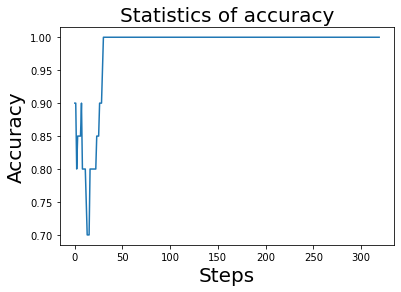

In [14]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

从上述打印的图像可以看到，在大约50步后，预测的准确率收敛于1，也就是说预测的准确率已经可以达到100%。

## 预测

最后，我们测试一下训练好的模型，将其应用在测试集上。

In [15]:
from mindspore import ops, Tensor                                            # 导入ops模块和Tensor模块

predict = np.argmax(ops.Softmax()(model.predict(Tensor(X_test))), axis=1)    # 使用建立的模型和测试样本，得到测试样本预测的分类
correct = model.eval(test_loader, dataset_sink_mode=False)                   # 计算测试样本应用训练好的模型的预测准确率

print("预测分类结果：", predict)                                              # 对于测试样本，打印预测分类结果
print("实际分类结果：", y_test)                                               # 对于测试样本，打印实际分类结果

print(correct)                                                               # 打印模型预测的准确率

预测分类结果： [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
实际分类结果： [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
{'Acc': 1.0}


从上述打印的可以看到，预测分类结果和实际分类结果完全一致，模型预测的准确率达到了100%。

至此，我们体验了如何通过搭建量子神经网络来解决经典机器学习中的经典问题——鸢尾花分类问题。相信大家也对使用MindQuantum有了更进一步的了解！期待大家挖掘更多的问题，充分发挥MindQuantum强大的功能！

若想查询更多关于MindQuantum的API，请点击：[https://mindspore.cn/mindquantum/](https://mindspore.cn/mindquantum/)。